In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
from scipy.fft import fft, fftfreq
import json

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [2]:
# %aimport experiments
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.DONOTUSE_ramsey_ef
imported experiments.single_qubit.DONOTUSE_randbench
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_pi_pulse_ZZ
imported

In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [4]:
expt_path=os.path.join(os.getcwd(),'data', 'data_231127')
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_231127


In [5]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join(os.getcwd(), config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and638_reset.yml


# Set the qubits/resonators to probe

In [6]:
qubits = [3, 1] # for eg-gf swap, always list the 2nd qubit here as the 2nd qubit in the order eg-gf

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [7]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [8]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

In [9]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq)
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to 5925000000.0
set power to 7.0


In [9]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Software version: 0.2.207
	Firmware timestamp: Mon Jul 24 13:57:32 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, blk 1, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, blk 2, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, blk 3, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC ti

# ZZ shifted pi pulses

## Pulse probe coupling spectroscopy

Sweep qubit A frequency after applying pi pulse to qubit B.

In [12]:
qubits = [1, 3] # for eg-gf swap, always list the 2nd qubit here as the 2nd qubit in the order eg-gf

In [15]:
qZZspec = meas.PulseProbeCouplingSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_coupling_spectroscopy_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span = 1
npts = 100

qZZspec.cfg.expt = dict(
    start=qZZspec.cfg.device.qubit.f_Q1_ZZ[qubits[1]]-span/2,
    # start=qZZspec.cfg.device.qubit.f_ge[qubits[0]]-span/2,
    # start=3458.5-span/2,
    step=span/npts,
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    pulseB=True, # Whether to apply pi pulse to qubit B
    length=1, # qubit 0 probe constant pulse length [us]
    gain=100, # qubit 0 const pulse gain
    pulse_type='gauss',
    qubits=qubits,
)

# qZZspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]

print(qZZspec.cfg)

qZZspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [30, 110, 105, 150], 'f_ge': [4140.530270731964, 3463.742568636059, 4800.079246546452, 4415.18623279066], 'f_Q1_ZZ': [3458.6082793015007, 0, 3462.660233985849, 3462.481397860399], 'f_ef': [3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869355], 'f_EgGf': [2682.783, 0, 2024.7, 2407.3], 'gs': [54.38663964, 52.60236201, 41.1249601, 6.26475719, 2.73059709, 6.00700312], 'ZZs': [0.0, -5.114594559749094, -0.18282363920479838, -0.498164234703836, -5.102823962105504, 0.0, -0.9444087654687792, -1.0606959776605436, -0.18631446427480114, -0.953190326496042, 0.0, -0.4841473294491152, -0.5065394094099247, -1.0909347449496636, -0.40800300690079894, 0.0], 'pulses': {'pi_ge': {'gain': [22882, 19375, 8131, 5854], 'sigma': [0.03157, 0.045, 0.07, 0.07043], 'type': 'gauss'}, 'pi_ef': {'gain': [13782, 21716, 23173, 22120], 'sigma': [0.02117, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [19733, 0, 20819, 20392], 'sigma': [0.0512, 0, 0.04364,

  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3462.3899700532797, HWHM 0.12714619626362753
Found peak in I at [MHz] 3462.385421125047, HWHM 0.11674431796925731
Found peak in Q at [MHz] 3462.895632225799, HWHM 0.143024782871282


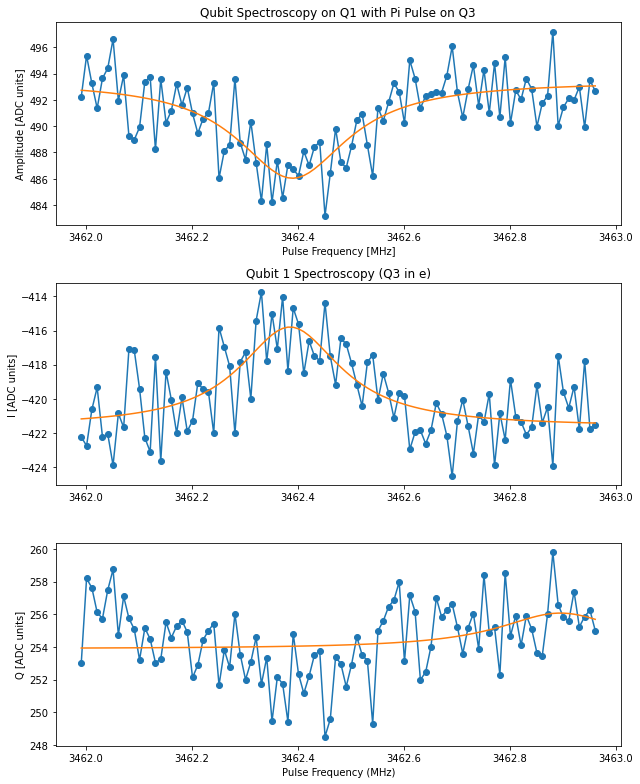

In [16]:
# # TESTING
# qZZspec = meas.PulseProbeEgGfSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00002_qubit_coupling_spectroscopy_qubit01.h5')
# data = qZZspec.analyze(data=temp_data, fit=True, sign=[[1, -1], [-1, -1]])
# qZZspec.display(data=data, fit=True)

qZZspec.analyze(fit=True, signs=[1, -1, 1])
qZZspec.display(fit=True, signs=[1, -1, 1])

In [55]:
qZZspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_qubit_coupling_spectroscopy_qubit01.h5


## Length rabi for Q1 with QA in e

In [51]:
lengthrabiZZ = meas.LengthRabiPiZZExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_ZZ_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

lengthrabiZZ.cfg.expt = dict(
    start=0, # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=101,
    reps=1000,
    gain=20000, # qubit gain [DAC units],
    pulse_type='gauss',
    qubits=qubits,
)
# lengthrabiZZ.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(lengthrabiZZ.cfg)
# lengthrabi.im[lengthrabi.cfg.aliases.soc].reset()
lengthrabiZZ.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [73, 128, 46, 58], 'f_ge': [826.6246419342525, 3470.204764189285, 153.92796237453135, 447.5819924260869], 'f_Q1_ZZ': [3468.889513688846, 3470.20476419, 3465.25270434, 3469.12083078], 'f_ef': [637.2764733473786, 3369.7243020025294, -71.90192894145498, 275.76433968698353], 'f_EgGf': [2009.9, -1, 2681.7, 2384.37], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [23801, 21866, 22539, 28755], 'sigma': [0.0403, 0.0197, 0.0433, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [30000, 16999, 20765, 29402], 'sigma': [0.02, 0.015, 0.035, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.018, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3000, 0, 2750, 3000], 'sigma': [0.396, 0, 0.232, 0.276], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [812.846, -807.358, -79.784, 81.67042225717739], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.9, 0.27, 0.27, 0.85]

  0%|          | 0/101 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 83.99916000000002, which is out of bounds 0.3535318181818182 to 53.02977272727273. Instead init to 26.691652272727275
Pi length from avgi data (qubit B) [us]: 0.021599656517148482
	Pi/2 length from avgi data (qubit B) [us]: 0.010799828258574241
Pi length from avgq data (qubit B) [us]: 0.021455783942806932
	Pi/2 length from avgq data (qubit B) [us]: 0.010727891971403466


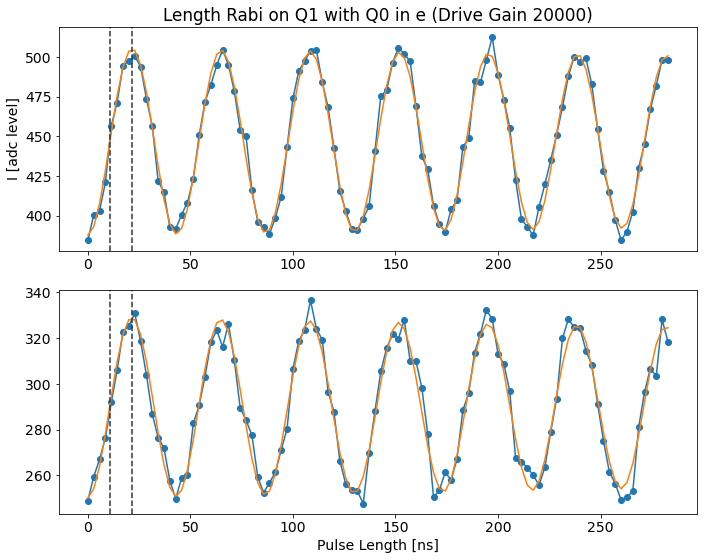

In [52]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabiZZ.analyze(data=temp_data, fit=True)

lengthrabiZZ.analyze(fit=True)
lengthrabiZZ.display(fit=True)

In [24]:
lengthrabiZZ.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220919\00000_length_rabi_ZZ_qubit31.h5


# 2Q swap frequencies

Estimate 2Q swap frequencies analytically

In [27]:
f_ge = np.array(yaml_cfg.device.qubit.f_ge) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)
f_Q1_ZZ = np.array(yaml_cfg.device.qubit.f_Q1_ZZ) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)
f_ef = np.array(yaml_cfg.device.qubit.f_ef) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)

print('f_EgGf: need indices 0, 2, 3')
print(f_ge[1] + f_ef[1] - f_ge)
print('f_EgGf_Q: indices 2, 3')
print(f_ge[2] + f_ef[2] - f_ge[1])
print(f_ge[3] + f_ef[3] - f_Q1_ZZ[0])

f_EgGf: need indices 0, 2, 3
[2686.53594683 3350.33023307 2033.76008793 2414.92850999]
f_EgGf_Q: indices 2, 3
5894.260105653073
5153.998192863016


## Pulse probe eg-gf spectroscopy

In [15]:
qEgGfspec = meas.PulseProbeEgGfSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EgGf_spectroscopy_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span = 40
npts = 150

qEgGfspec.cfg.expt = dict(
    # start=qEgGfspec.cfg.device.qubit.f_ge[1] - span/2, # Eg-Gf probe frequency [MHz]
    start=qEgGfspec.cfg.device.qubit.f_EgGf[qubits[0]] - span/2, # Eg-Gf probe frequency [MHz]
    # start=1900,
    step=span/npts,
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    length=2, # Eg-Gf probe constant pulse length [us]
    gain=3000, # Eg-Gf const pulse gain
    qubits=qubits,
)
# qEgGfspec.cfg.device.readout.relax_delay = [50]*4
# qEgGfspec.cfg.device.readout.relax_delay = [100, 100, 100, 100]
# qEgGfspec.cfg.device.readout.length = [5, 5, 5, 5]

print(qEgGfspec.cfg)

qEgGfspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [24, 96, 30, 58], 'f_ge': [806.087775593827, 3464.4496477749913, 145.572034953271, 425.57], 'f_Q1_ZZ': [3463.6655790699174, 0, 3459.718643790527, 3463.5163174610875], 'f_ef': [617.0457654660589, 3364.2604416148333, -78.90376315971923, 275.76433968698353], 'f_EgGf': [2022.6223138, 3364.26044161, 2683.13805444, 2403.14008939], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [30306, 22147, 24653, 28755], 'sigma': [0.0326, 0.01836, 0.0403, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [13626, 13553, 31065, 29402], 'sigma': [0.025, 0.025, 0.025, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [30000, 0, 15880, 30000], 'sigma': [0.022877223175459725, 0, 0.05739835717369027, 0.016160253718707353], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3450, 0, 2750, 2850], 'sigma': [0.2186, 0, 0.232, 0.29], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [818.946, -812.617, -73.825, 87.436], 'lo_sideband'

  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in avgi data (qubit A) at [MHz] 2011.0772790316635, HWHM 1.0630988234280279
Found peak in avgq data (qubit A) at [MHz] 2011.059302455054, HWHM 0.9029036822409753
Found peak in avgi data (qubit B) at [MHz] 2011.0325283890313, HWHM 0.9407213882735002
Found peak in avgq data (qubit B) at [MHz] 2011.0143256501299, HWHM 0.9636483374316271


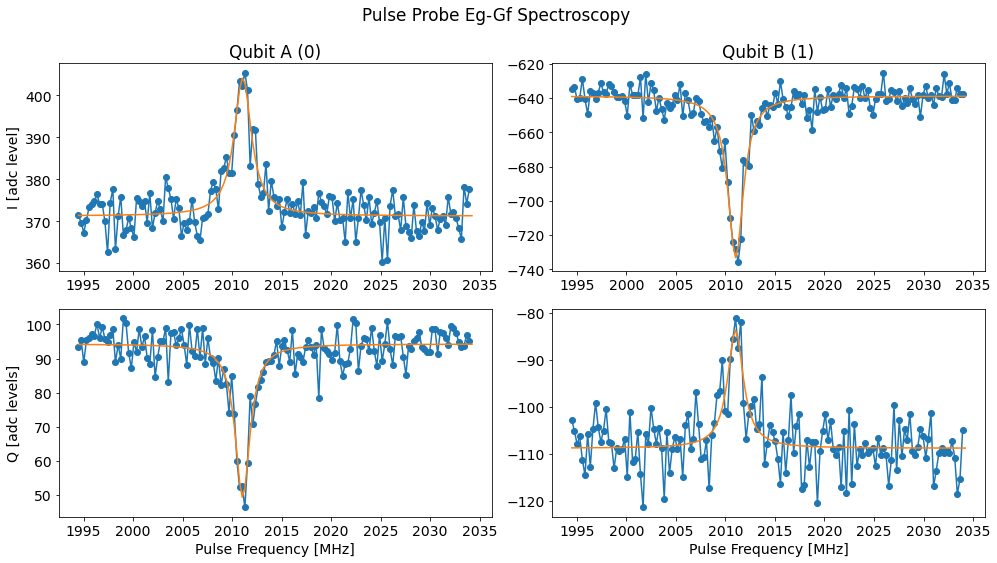

In [15]:
# # TESTING
# qEgGfspec = meas.PulseProbeEgGfSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00002_qubit_EgGf_spectroscopy_qubit01.h5')
# data = qEgGfspec.analyze(data=temp_data, fit=True, sign=[[1, -1], [-1, -1]])
# qEgGfspec.display(data=data, fit=True)

# qEgGfspec.analyze(fit=False)
sign = [[1, -1], [-1, 1]] # [iA, qA], [iB, qB]
qEgGfspec.analyze(fit=True, sign=sign)
qEgGfspec.display(fit=True, sign=sign)

In [16]:
qEgGfspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_221007\00000_qubit_EgGf_spectroscopy_qubit01.h5


### Pulse probe EgGF power sweep

In [18]:
sweepspecEgGf = meas.PulseProbeEgGfSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"pulse_probe_ef_len_sweep_spectroscopy_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span_f = 75
npts_f = 150
# npts_f = 10

span_len = 20
npts_len = 10
# npts_len = 3

sweepspecEgGf.cfg.expt = dict(
    start_f=sweepspecEgGf.cfg.device.qubit.f_EgGf[qubits[0]] - span_f/2, # Eg-Gf probe frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    start_len=1,
    step_len=int(span_len/npts_len), # len step size
    expts_len=npts_len, # Number experiments stepping len from start
    reps=500,
    rounds=40, # Number averages per point
    gain=30000, # ef const pulse length [us]
    qubits=qubits,
)
sweepspecEgGf.cfg.device.readout.relax_delay = [100, 100, 100, 100]
sweepspecEgGf.cfg.device.readout.length = [5, 5, 5, 5]
sweepspecEgGf.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/10 [00:00<?, ?it/s]

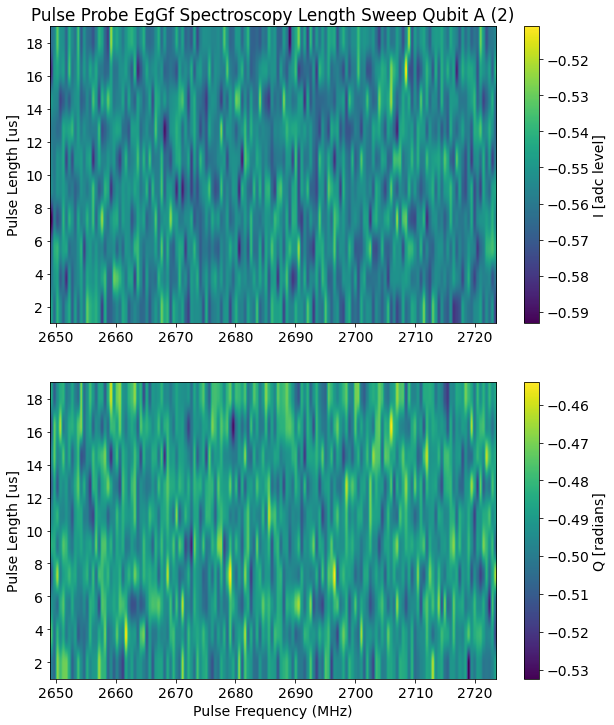

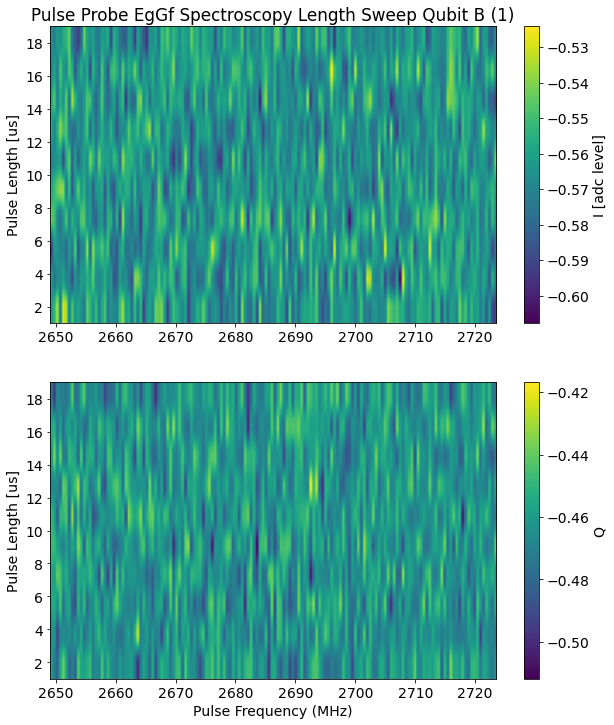

In [19]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

sweepspecEgGf.analyze()
sweepspecEgGf.display()

## Rabi eg-gf chevron (freq vs. amplitude)

In [31]:
qubits = [2, 1] # for eg-gf swap, always list the 2nd qubit here as the 2nd qubit in the order eg-gf

In [44]:
rabiEgGfFreqGainChevron = meas.EgGfFreqGainChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rabi_EgGf_freqgain_chevron_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span_gain = 20000
npts_gain = 20
# span_gain = 0
# npts_gain = 40

span_f = 10 # MHz
npts_f = 15
# span_f = 0
# npts_f = 40

rabiEgGfFreqGainChevron.cfg.expt = dict(
    start_gain=10000, # qubit gain [dac level]
    step_gain=int(span_gain/npts_gain), # [dac level]
    expts_gain=npts_gain,
    # start_f=5916,
    # start_f=rabiEgGfFreqGainChevron.cfg.device.qubit.f_EgGf[qubits[0]] - span_f/2, # start freq [MHz],
    start_f=rabiEgGfFreqGainChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]] - span_f/2, # start freq [MHz],
    # start_f=rabiEgGfFreqGainChevron.cfg.device.qubit.f_EgGf[qubits[0]] + 5 - span_f/2, # start freq [MHz],
    step_f=span_f/npts_f, # freq step, 
    expts_f=npts_f, # number of different freq experiments, 
    rounds=10,
    reps=80,
    pi_EgGf_sigma=0.450, # gaussian sigma/const pulse length, overrides config [us]
    pulse_type='flat_top',
    setup_ZZ=0, # add an extra pi pulse on another qubit other than the 2 qubits for the swap
    qDrive=qubits[0],
    # qDrive=1,
    qubits=qubits,
)

# rabiEgGfFreqGainChevron.cfg.device.readout.readout_length = [15, 15] # [us]
# rabiEgGfFreqGainChevron.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

print(rabiEgGfFreqGainChevron.cfg)

rabiEgGfFreqGainChevron.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'f_ge': [4114.583845316948, 3450.7895590725893, 4767.359704214145, 4386.191282153509], 'f_ef': [3887.2240728229826, 3350.330233073566, 4577.689960511519, 4213.394642821962], 'f_Q1_ZZ': [3445.5877321124563, 0, 3449.6936121756476, 3449.4923401580063], 'f_Q_ZZ1': [4109.2353064588515, 0, 4766.264226603061, 4384.890337223246], 'f_EgGf': [2686.53594683, -1, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [-1, -1, 5896, 5152.0], 'gs': [53.07454288679892, 56.33900830945526, 44.06651851927302, 4.826787539590175, 2.201102542443888, 6.280490149923522], 'ZZs': [0.0, -5.132149880358156, -0.11720448229698377, -0.46755316331291397, -5.132149880358156, 0.0, -1.1258892837849999, -1.2798980910865794, -0.17297849, -1.1258892837849999, 0.0, -0.5808573560734658, -0.46704822, -1.2798980910865794, -0.4730200905169113, 0.0], 'T1': [10, 88, 33, 75], 'pulses': {'pi_ge': {'gain': [21052, 25413, 2705, 2516], 'sigma': [0.02, 0.1, 0.015, 0.015], 'type': 'gauss'}, 'pi_ef': {'gain': [20819, 29107, 18

  0%|          | 0/15 [00:00<?, ?it/s]

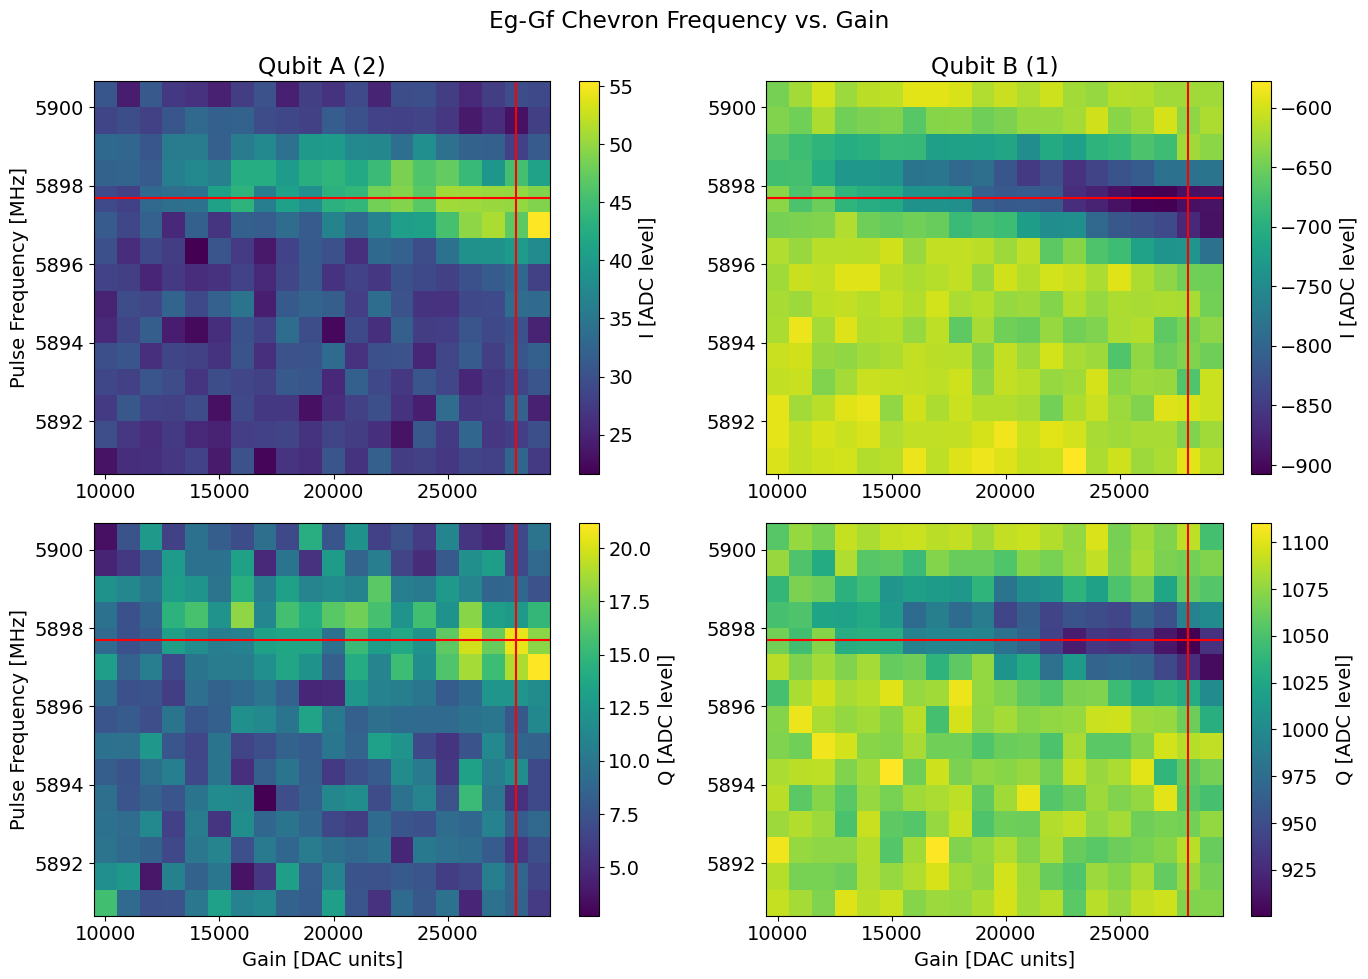

In [48]:
# # TESTING
# rabiEgGfFreqGainChevron = meas.EgGfFreqGainChevronExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_rabi_EgGf_gainlen_chevron_qubit01.h5')
# rabiEgGfFreqGainChevron.cfg.expt = attrs['config']['expt']
# print(temp_data.keys())
# rabiEgGfFreqGainChevron.display(data=temp_data, saveplot=True) #, plot_freq=2024.5, plot_gain=2125)
# data = rabiEgGfChevron.analyze(data=temp_data, fit=True)
# rabiEgGfChevron.display(data=data, fit=True)

rabiEgGfFreqGainChevron.analyze(data=None)
rabiEgGfFreqGainChevron.display(data=None, plot_freq=5897.7, plot_gain=28000)

In [38]:
rabiEgGfFreqGainChevron.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00002_rabi_EgGf_freqgain_chevron_qubit31.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_230217\\00002_rabi_EgGf_freqgain_chevron_qubit31.h5'

## Rabi eg-gf chevron (freq vs. len)

In [52]:
rabiEgGfFreqLenChevron = meas.EgGfFreqLenChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rabi_EgGf_freqlen_chevron_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

# span_f = 8 # MHz
span_f = 5 # MHz
npts_f = 15
    
rabiEgGfFreqLenChevron.cfg.expt = dict(
    # start_f=2686.5 - span_f/2, # start freq [MHz],
    # start_f=rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf[qubits[0]] - span_f/2, # start freq [MHz],
    start_f=rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]] - span_f/2, # start freq [MHz],
    step_f=span_f/npts_f, # freq step, 
    expts_f=npts_f, # number of different freq experiments, 
    start_len=0.300, # pulse length (sigma) [us]
    step_len=soc.cycles2us(15), # [us]
    expts_len=10,
    # gain=18000,
    reps=2000,
    pulse_type='flat_top',
    # post_process='scale', #'threshold',
    # singleshot_reps=10000,
    measure_f=False,
    setup_ZZ=None, # 0, # add an extra pi pulse on another qubit other than the 2 qubits for the swap
    qDrive=qubits[0],
    # qDrive=1,
    qubits=qubits,
)

# rabiEgGfFreqLenChevron.cfg.device.readout.readout_length = [15, 15] # [us]
# rabiEgGfFreqLenChevron.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

print(rabiEgGfFreqLenChevron.cfg)

import Pyro4.util
try:
    rabiEgGfFreqLenChevron.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'f_ge': [4114.583845316948, 3450.7895590725893, 4767.359704214145, 4386.191282153509], 'f_ef': [3887.2240728229826, 3350.330233073566, 4577.689960511519, 4213.394642821962], 'f_Q1_ZZ': [3445.5877321124563, 0, 3449.6936121756476, 3449.4923401580063], 'f_Q_ZZ1': [4109.2353064588515, 0, 4766.264226603061, 4384.890337223246], 'f_EgGf': [2686.53594683, -1, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [-1, -1, 5897.7, 5152.0], 'gs': [53.07454288679892, 56.33900830945526, 44.06651851927302, 4.826787539590175, 2.201102542443888, 6.280490149923522], 'ZZs': [0.0, -5.132149880358156, -0.11720448229698377, -0.46755316331291397, -5.132149880358156, 0.0, -1.1258892837849999, -1.2798980910865794, -0.17297849, -1.1258892837849999, 0.0, -0.5808573560734658, -0.46704822, -1.2798980910865794, -0.4730200905169113, 0.0], 'T1': [10, 88, 33, 75], 'pulses': {'pi_ge': {'gain': [21052, 25413, 2705, 2516], 'sigma': [0.02, 0.1, 0.015, 0.015], 'type': 'gauss'}, 'pi_ef': {'gain': [20819, 29107, 

  0%|          | 0/15 [00:00<?, ?it/s]

min qA I 23.379073845152895
max qA I 32.646608327911515
[[10  1]]
freq 5898.866666666667 len 369.7544642857143
min qB I -684.4486763175016
max qB I -618.3881353285623
[[5 8]]
freq 5897.2 len 613.8950892857142


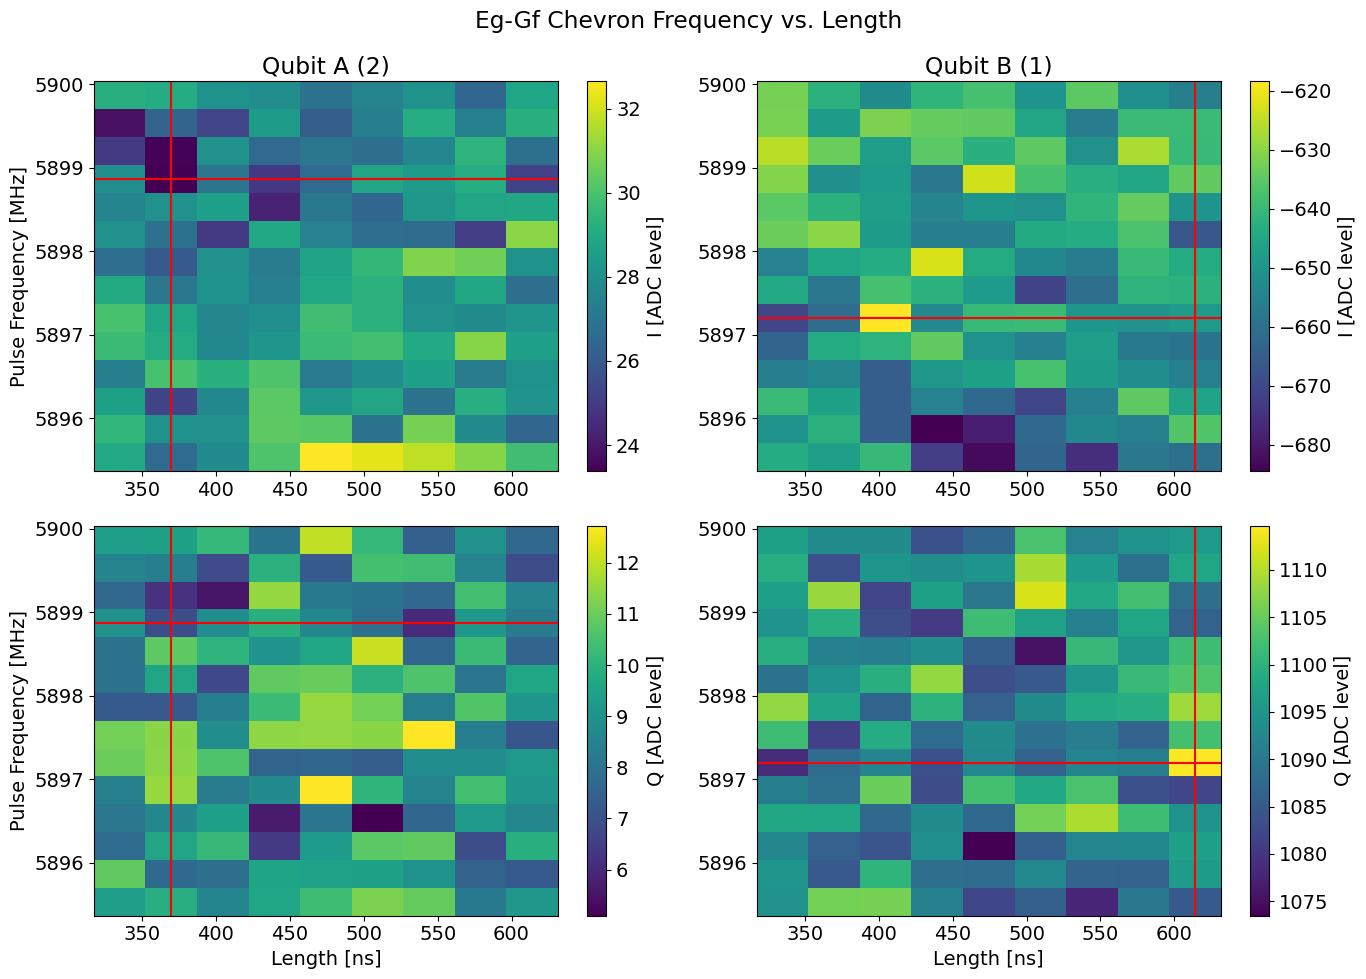

In [53]:
# TESTING
# rabiEgGfChevron = meas.EgGfFreqLenChevronExperiment(config_file=config_path)
# # rabiEgGfChevron.cfg.expt = dict(sigma_test=0.400, singleshot=False,)
# temp_data, attrs = prev_data(expt_path, '00001_rabi_EgGf_gainlen_chevron_qubit01.h5')
# rabiEgGfChevron.cfg.expt = attrs['config']['expt']
# print(temp_data.keys())
# # data = rabiEgGfChevron.analyze(data=temp_data, fit=True)
# rabiEgGfChevron.display(data=temp_data)
# rabiEgGfChevron.display(data=temp_data, saveplot=True)
rabiEgGfFreqLenChevron.analyze(data=None)
rabiEgGfFreqLenChevron.display(data=None) #, plot_freq=5892.65, plot_len=512.99)

In [189]:
rabiEgGfFreqLenChevron.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00002_rabi_EgGf_freqlen_chevron_qubit01.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_230217\\00002_rabi_EgGf_freqlen_chevron_qubit01.h5'

## 3D sweep to optimize length, gain, freq

In [108]:
2027 - np.arange(expts_gain)*(10/8000*step_gain)

array([2027. , 2024.5, 2022. , 2019.5, 2017. ])

In [ ]:
start_gain = 2000
step_gain = 2000
expts_gain = 5
gain_sweep = start_gain + step_gain * np.arange(expts_gain)
print(gain_sweep)

sweep2d_expt_progs = []

for ig, gain in enumerate(gain_sweep):
    print('Now setting gain to', gain)
    rabiEgGfFreqLenChevron = meas.EgGfFreqLenChevronExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"rabi_EgGf_freqlen_chevron_qubit{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )

    span_f = 6 # MHz
    npts_f = 20

    freq_center_pts = 2412 - np.arange(expts_gain)*(10/6000*step_gain)
    if ig==0: print('Freq sweep will be centered at', freq_center_pts)

    rabiEgGfFreqLenChevron.cfg.expt = dict(
        start_f=freq_center_pts[ig] - span_f/2,
        step_f=span_f/npts_f, # freq step, 
        expts_f=npts_f, # number of different freq experiments, 
        start_len=soc.cycles2us(10), # pulse length (sigma) [us]
        step_len=soc.cycles2us(12), # [us]
        expts_len=30,
        gain=gain,
        reps=1000,
        pulse_type='flat_top',
        post_process='scale',
        singleshot_reps=15000,
        qubits=qubits,
    )

    # rabiEgGfFreqLenChevron.cfg.device.readout.readout_length = [15, 15] # [us]
    # rabiEgGfFreqLenChevron.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

    # print(rabiEgGfFreqLenChevron.cfg)

    import Pyro4.util
    try:
        rabiEgGfFreqLenChevron.go(analyze=False, display=False, progress=True, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
    
    rabiEgGfFreqLenChevron.analyze(data=None)
    rabiEgGfFreqLenChevron.display(data=None)
    sweep2d_expt_progs.append(rabiEgGfFreqLenChevron)

## Length Rabi eg-gf single sweep

In [ ]:
# soc.us2cycles(10)*150
5*soc.cycles2us(4, gen_ch=4)*1e3

33.38675213675214

{'device': {'qubit': {'f_ge': [4114.583845316948, 3450.7895590725893, 4767.359704214145, 4386.191282153509], 'f_ef': [3887.2240728229826, 3350.330233073566, 4577.689960511519, 4213.394642821962], 'f_Q1_ZZ': [3445.5877321124563, 0, 3449.6936121756476, 3449.4923401580063], 'f_Q_ZZ1': [4109.2353064588515, 0, 4766.264226603061, 4384.890337223246], 'f_EgGf': [2686.53594683, -1, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [-1, -1, 5892.65, 5152.0], 'gs': [53.07454288679892, 56.33900830945526, 44.06651851927302, 4.826787539590175, 2.201102542443888, 6.280490149923522], 'ZZs': [0.0, -5.132149880358156, -0.11720448229698377, -0.46755316331291397, -5.132149880358156, 0.0, -1.1258892837849999, -1.2798980910865794, -0.17297849, -1.1258892837849999, 0.0, -0.5808573560734658, -0.46704822, -1.2798980910865794, -0.4730200905169113, 0.0], 'T1': [10, 88, 33, 75], 'pulses': {'pi_ge': {'gain': [21052, 25413, 2705, 2516], 'sigma': [0.02, 0.1, 0.015, 0.015], 'type': 'gauss'}, 'pi_ef': {'gain': [20819, 29107,

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (2)


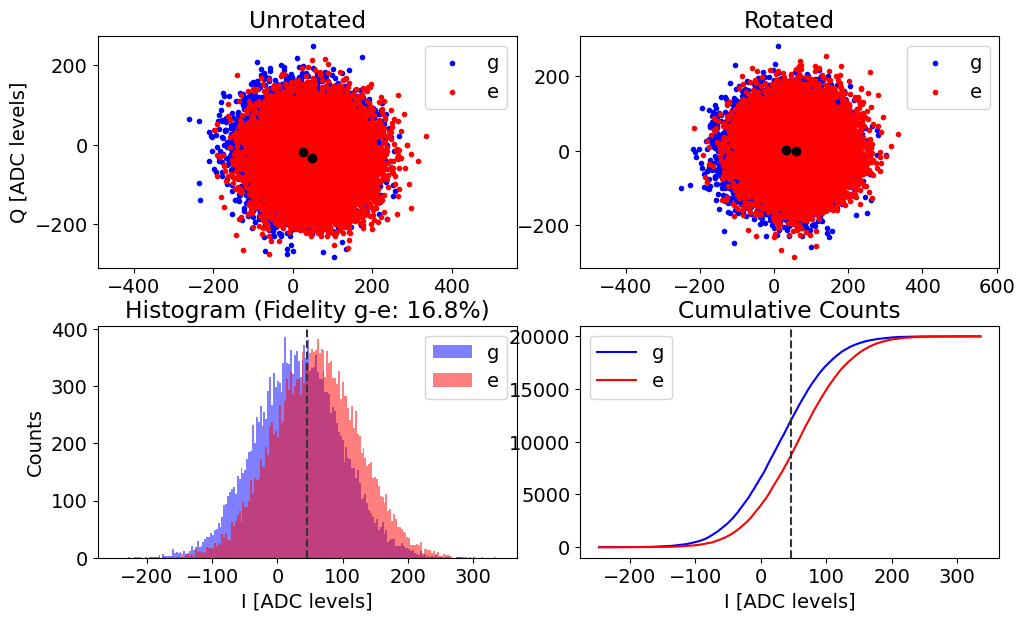

ge fidelity (%): 16.77041926048151 	 angle (deg): 35.86205605231054 	 threshold ge: 45.861594012756115
Qubit  (1)


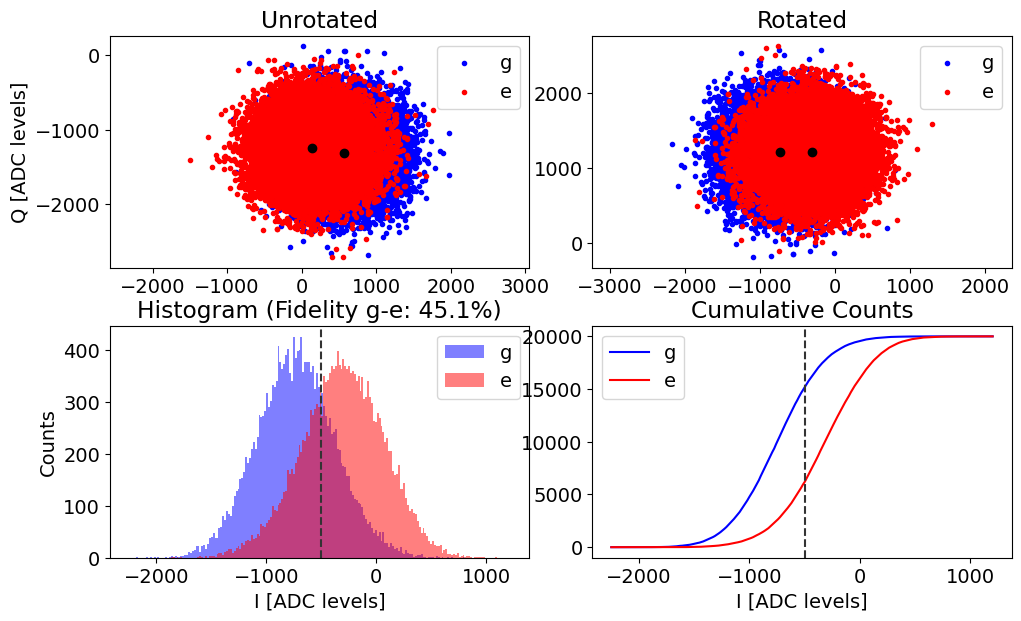

ge fidelity (%): 45.05112627815696 	 angle (deg): -172.25391492482763 	 threshold ge: -498.1004980426369
thresholds=[0, -498.1004980426369, 45.861594012756115, 0]
angles=[0, -172.25391492482763, 35.86205605231054, 0]
ge_avgs=[array([0., 0., 0., 0.]), [557.7531628171763, -1303.1067477878985, 138.67930029277815, -1246.8417215354586], [26.519383929733245, -17.74749053350683, 48.81259684450227, -33.85337329212752], array([0., 0., 0., 0.])]


  0%|          | 0/50 [00:00<?, ?it/s]

In [39]:
lengthrabiEgGf = meas.LengthRabiEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

lengthrabiEgGf.cfg.expt = dict(
    start=soc.cycles2us(0), # pulse length (sigma) [us]
    step=soc.cycles2us(8), # [us]
    # step=0.371,
    expts=50,
    reps=2000,
    # gain=4250, # qubit gain [DAC units],
    pulse_type='flat_top',
    post_process='threshold',
    singleshot_reps=20000,
    measure_f=True,
    setup_ZZ=None, # add an extra pi pulse on another qubit other than the 2 qubits for the swap
    qDrive=qubits[0],
    # qDrive=1,
    qubits=qubits,
)

# lengthrabiEgGf.cfg.device.readout.readout_length = [10,5] # [us]
print(lengthrabiEgGf.cfg)
# lengthrabiEgGf.im[lengthrabiEgGf.cfg.aliases.soc].reset()
import Pyro4.util
try:
    lengthrabiEgGf.acquire(progress=True, debug=True)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

Attempted to init fitparam 1 to 20.845714285714287, which is out of bounds 0.11200000000000002 to 16.8. Instead init to 8.456
Attempted to init fitparam 4 to 0.4711610421474034, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Exception: Each lower bound must be strictly less than each upper bound.
Pi length from avgi data (qubit A) [us]: 0.08462818330256527
	Pi/2 length from avgi data (qubit A) [us]: 0.04231409165128264
	Decay time [us]: 0.2678571428571429
Pi length from avgq data (qubit A) [us]: 0.5019106441776234
	Pi/2 length from avgq data (qubit A) [us]: 0.2509553220888117
	Decay time [us]: 1.288290785371742
Pi length from avgi data (qubit B) [us]: 0.5025399013011377
	Pi/2 length from avgi data (qubit B) [us]: 0.25126995065056884
	Decay time [us]: 2.270691317288015
Exception: 'fitB_avgq'


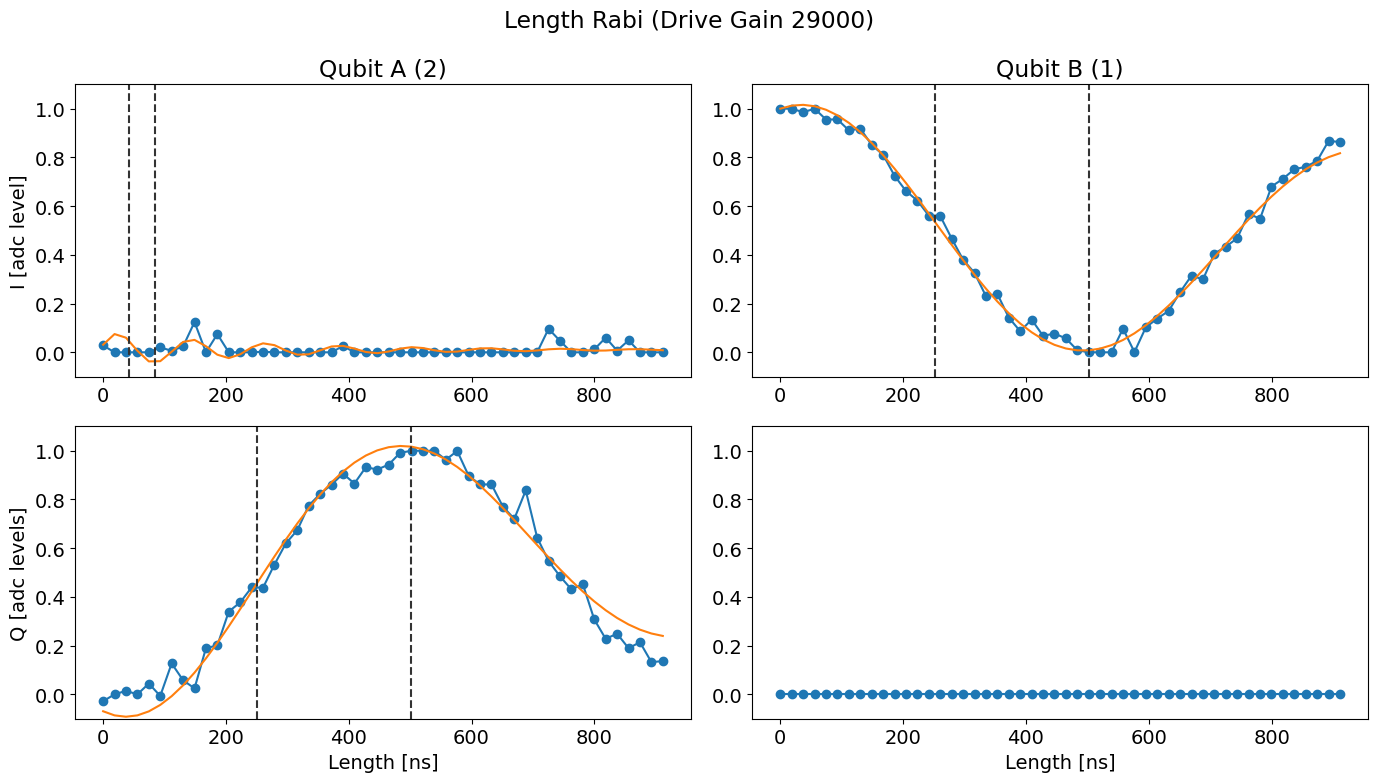

[[8753 2877 6154 2216]
 [3552 8371 2390 5687]
 [6183 2133 8771 2913]
 [2678 5848 3514 7960]]


In [40]:
# # TESTING
# lengthrabiEgGf = meas.LengthRabiEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_length_rabi_qubit01.h5')
# data = lengthrabiEgGf.analyze(data=temp_data, fit=True)
# lengthrabiEgGf.display(data=data, fit=False)

lengthrabiEgGf.analyze(fit=True)
lengthrabiEgGf.display(fit=True)
print(lengthrabiEgGf.data['counts_calib'])

In [14]:
lengthrabiEgGf.save_data()

Saving c:\_Lib\python\rfsoc\qram_4QR2_BF5\data\data_230717\00000_length_rabi_EgGf_qubit21.h5


## Amplitude Rabi eg-gf single sweep

In [10]:
amprabiEgGf = meas.AmplitudeRabiEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span = 1000
npts = 101
    
amprabiEgGf.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    # step=0.001,
    rounds=10,
    reps=500,
    # pi_EgGf_sigma=0.600, # gaussian sigma/const pulse length, overrides config [us]
    pulse_type='const',
    qubits=qubits,
    singleshot=False,
)

# amprabiEgGf.cfg.device.readout.readout_length = [15, 15] # [us]
# amprabiEgGf.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

print(amprabiEgGf.cfg)

import Pyro4.util
try:
    amprabiEgGf.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'T1': [30, 96, 9, 58], 'f_ge': [146.3200507751049, 3464.1798421793665, 808.0847336808625, 426.8701802662663], 'f_Q1_ZZ': [3459.6967629797664, 0, 3463.7374335056006, 3463.5464893503636], 'f_ef': [-78.90376315971923, 3364.253, 611.098326885819, 254.36098271568733], 'f_EgGf': [2678.7, 0, 2010.8, 2395.5], 'ZZs': [0.0, -4.7126775455997745, -0.10534620937775685, -0.28344964409794215, -4.236078028296106, 0.0, -0.16869289545775246, -0.2784781391173965, 0.5146242128746508, -0.12676679271078228, 0.0, -0.06125637291711428, 3.0556426555347116, 2.6356995614617063, 3.312733462014023, 0.0], 'pulses': {'pi_ge': {'gain': [24653, 20197, 27992, 24647], 'sigma': [0.0403, 0.02, 0.04, 0.025], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [31065, 13553, 16026, 21903], 'sigma': [0.025, 0.025, 0.025, 0.0166], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [27345, 0, 27988, 29136], 'sigma': [0.015, 0, 0.015, 0.015], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gai

  0%|          | 0/10 [00:00<?, ?it/s]

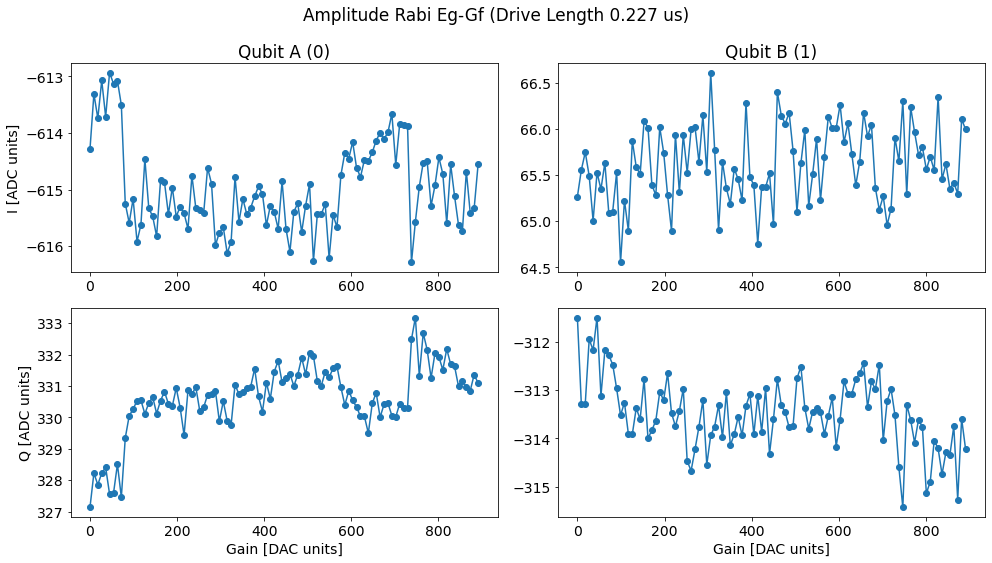

In [11]:
# # TESTING
# amprabiEgGf = meas.AmplitudeRabiEgGfExperiment(config_file=config_path)
# amprabiEgGf.cfg.expt = dict(sigma_test=0.400, singleshot=False,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EgGf_qubit01.h5')
# data = amprabiEgGf.analyze(data=temp_data, fit=True)
# amprabiEgGf.display(data=data, fit=True)

# # apply mask onto data
# temp_data = dict()
# for key, value in amprabiEgGf.data.items():
#     if len(np.shape(value)) > 1:
#         temp_data.update({key:np.array([value[0][:50], value[1][:50]])})
#     else: temp_data.update({key:value[:50]})

amprabiEgGf.analyze(data=None, fit=True)
amprabiEgGf.display(data=None, fit=False)

In [ ]:
amprabiEgGf.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220919\00000_amp_rabi_EgGf_qubit01.h5


In [ ]:
prog = amprabiEgGf.prog
shot_avg = 10
threshold = amprabiEgGf.cfg.device.readout.threshold
bufi = np.array([prog.di_buf[i] for i, ch in enumerate(prog.ro_chs)])
avgi = []
for bufi_ch in bufi:
    # drop extra shots that aren't divisible into averages
    new_bufi_ch = bufi_ch[:len(bufi_ch) - (len(bufi_ch) % shot_avg)]
    # average over shots_avg number of consecutive shots
    new_bufi_ch = np.reshape(new_bufi_ch, (len(new_bufi_ch)//shot_avg, shot_avg))
    new_bufi_ch = np.average(new_bufi_ch, axis=1)
    avgi.append(new_bufi_ch)
avgi = np.array(avgi)
shots = np.array([np.heaviside(avgi[i]/prog.ro_chs[ch].length-threshold[i], 0) for i, ch in enumerate(prog.ro_chs)])

qubits = prog.cfg.expt.qubits
# get the shots for the qubits we care about
shots = np.array([shots[prog.adc_chs[q]] for q in qubits])

# data is returned as n00, n01, n10, n11 measured for the two qubits
n00 = np.sum(np.logical_and(np.logical_not(shots[0]), np.logical_not(shots[1])))
n01 = np.sum(np.logical_and(np.logical_not(shots[0]), shots[1]))
n10 = np.sum(np.logical_and(shots[0], np.logical_not(shots[1])))
n11 = np.sum(np.logical_and(shots[0], shots[1]))
print(n00, n01, n10, n11)

50 23 16 11
